In [1]:
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

Using device: cuda


## Dataset

In [2]:
def inf_train_gen(n_grid_points: int = 128, batch_size: int = 200, device: str = "cpu") -> Tensor:
    assert n_grid_points % 4 == 0, "number of grid points has to be divisible by 4"
    
    n_grid_points = n_grid_points // 4
    
    x1 = torch.randint(low=0, high=n_grid_points * 4, size=(batch_size,), device=device)
    samples_x2 = torch.randint(low=0, high=n_grid_points, size=(batch_size,), device=device)
    
    x2 = (
        samples_x2
        + 2 * n_grid_points
        - torch.randint(low=0, high=2, size=(batch_size,), device=device) * 2 * n_grid_points
        + (torch.floor(x1 / n_grid_points) % 2) * n_grid_points
    )
    
    x_end = 1.0 * torch.cat([x1[:, None], x2[:, None]], dim=1)

    return x_end.long()

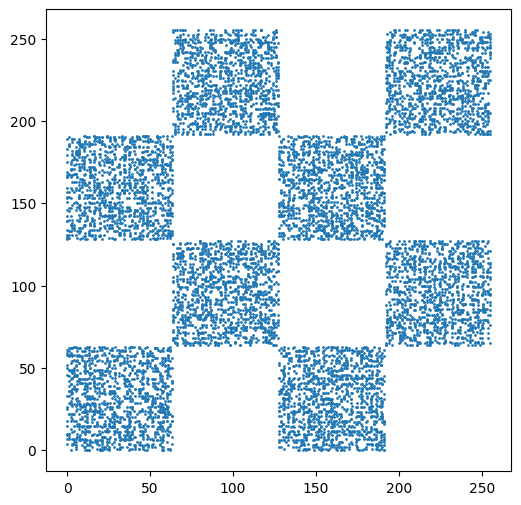

In [3]:
# Visulize dataset
samples = inf_train_gen(256, 10000)
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.show()

## Training

In [4]:
from models.discrete_diffusion.udm import UniformDiffusion
from models.discrete_diffusion.utils.parametrizations import subs_parametrization
from models.denoising_models.mlp import MLP

batch_size = 64
train_steps = 20000
vocab_size = 256
num_categories = vocab_size
input_shape = (2,)
num_timesteps = 1000
lr = 1e-3

model = UniformDiffusion(
    denoising_model=MLP(
        input_shape=input_shape,
        num_categories=num_categories,
        embed_dim=64,
        hidden_dim=256,
        encode_time=True,
        n_hidden_layers=1,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    noise_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="cosine",
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_steps)

Step 100/20000, Loss (EWMA): 11.5608, LR: 0.001000
Step 200/20000, Loss (EWMA): 11.4134, LR: 0.001000
Step 300/20000, Loss (EWMA): 10.8926, LR: 0.000999
Step 400/20000, Loss (EWMA): 10.7380, LR: 0.000999
Step 500/20000, Loss (EWMA): 11.6273, LR: 0.000998
Step 600/20000, Loss (EWMA): 10.8849, LR: 0.000998
Step 700/20000, Loss (EWMA): 10.9703, LR: 0.000997
Step 800/20000, Loss (EWMA): 11.0788, LR: 0.000996
Step 900/20000, Loss (EWMA): 11.3160, LR: 0.000995
Step 1000/20000, Loss (EWMA): 10.9518, LR: 0.000994
Step 1100/20000, Loss (EWMA): 11.0601, LR: 0.000993
Step 1200/20000, Loss (EWMA): 10.7140, LR: 0.000991
Step 1300/20000, Loss (EWMA): 10.7381, LR: 0.000990
Step 1400/20000, Loss (EWMA): 10.5962, LR: 0.000988
Step 1500/20000, Loss (EWMA): 10.5879, LR: 0.000986
Step 1600/20000, Loss (EWMA): 10.7960, LR: 0.000984
Step 1700/20000, Loss (EWMA): 11.4074, LR: 0.000982
Step 1800/20000, Loss (EWMA): 11.1702, LR: 0.000980
Step 1900/20000, Loss (EWMA): 10.7692, LR: 0.000978
Step 2000/20000, Loss

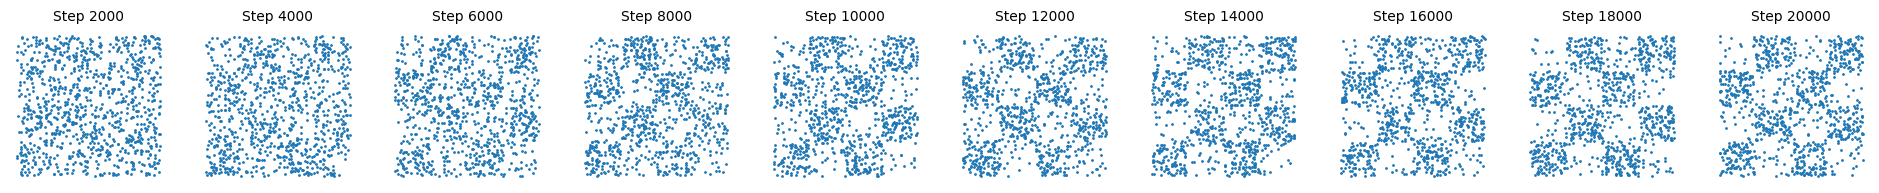

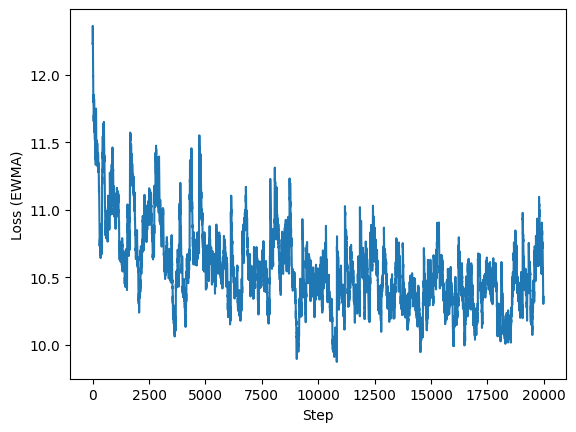

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(24, 2))
fig_idx = 0

losses = []
loss_ewma = None

for step in range(train_steps):
    x = inf_train_gen(n_grid_points=vocab_size, batch_size=batch_size, device=device)
    
    model.train()
    optimizer.zero_grad()
    loss = model(x)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if loss_ewma is None:
        loss_ewma = loss.item()
    else:
        loss_ewma = 0.99 * loss_ewma + 0.01 * loss.item()
    losses.append(loss_ewma)
    
    if (step + 1) % 100 == 0:
        print(f"Step {step + 1}/{train_steps}, Loss (EWMA): {loss_ewma:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
        
    if (step + 1) % (train_steps // 10) == 0:
        model.eval()
        with torch.no_grad():
            samples = model.sample(num_samples=1000, device=device).cpu().numpy()
        ax[fig_idx].scatter(samples[:, 0], samples[:, 1], s=1)
        ax[fig_idx].set_title(f"Step {step + 1}", fontsize=10)
        ax[fig_idx].axis('off')
        fig_idx += 1
        
plt.show()

plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss (EWMA)')
plt.show()

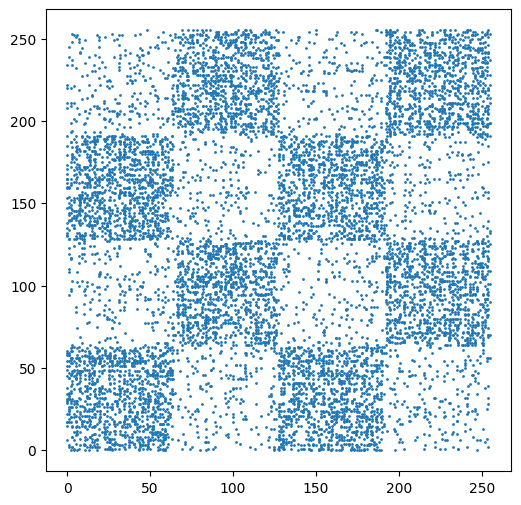

In [6]:
# Visualize model samples
model.eval()
with torch.no_grad():
    samples = model.sample(num_samples=10000, device=device).cpu().numpy()
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.show()

In [7]:
# store model weights
torch.save(model.state_dict(), '../model_weights/udm_checkerboard_256.pth')